In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

#import F
from torch.nn import functional as F

In [2]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
image_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize([0.5], [0.5]),transforms.Lambda(lambda x : x.to(device))
])


In [4]:
from torchvision import datasets

In [5]:
# Creating training and testing datasets
train_dataset = MNIST(root='./MnistDataset', train=True, transform=image_transform, download=True)
validation_dataset = MNIST(root='./MnistDataset', train=False, transform=image_transform, download=True)

In [6]:
print('Train dataset:', len(train_dataset))
print('Valid dataset:', len(validation_dataset))

Train dataset: 60000
Valid dataset: 10000


In [7]:
# Set up the dataloaders
from torch.utils.data import DataLoader
batch_size = 128

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationLoader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        
        # Make encoder to accept 28*28 images across 1 channel
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), # 14*14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7*7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256), # 256
            nn.ReLU()
        )
        
        # Create the latent space
        self.fc_mu = nn.Linear(256, 2)
        self.fc_log_var = nn.Linear(256, 2)
            
        # Create the decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14*14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28*28
            nn.Tanh()
        )
        
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        z = self.reparameterize(mu, log_var)
        x = self.decoder(z)
        return x, mu, log_var

In [9]:
from torchsummary import summary
model = VariationalAutoEncoder().to(device)
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─Conv2d: 2-3                       [-1, 64, 7, 7]            18,496
|    └─ReLU: 2-4                         [-1, 64, 7, 7]            --
|    └─Flatten: 2-5                      [-1, 3136]                --
|    └─Linear: 2-6                       [-1, 256]                 803,072
|    └─ReLU: 2-7                         [-1, 256]                 --
├─Linear: 1-2                            [-1, 2]                   514
├─Linear: 1-3                            [-1, 2]                   514
├─Sequential: 1-4                        [-1, 1, 28, 28]           --
|    └─Linear: 2-8                       [-1, 256]                 768
|    └─ReLU: 2-9                         [-1, 256]                 --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─Conv2d: 2-3                       [-1, 64, 7, 7]            18,496
|    └─ReLU: 2-4                         [-1, 64, 7, 7]            --
|    └─Flatten: 2-5                      [-1, 3136]                --
|    └─Linear: 2-6                       [-1, 256]                 803,072
|    └─ReLU: 2-7                         [-1, 256]                 --
├─Linear: 1-2                            [-1, 2]                   514
├─Linear: 1-3                            [-1, 2]                   514
├─Sequential: 1-4                        [-1, 1, 28, 28]           --
|    └─Linear: 2-8                       [-1, 256]                 768
|    └─ReLU: 2-9                         [-1, 256]                 --
| 

In [10]:
def lossFunction(recon_x, x, mu, log_var):
    MSE = F.mse_loss(recon_x, x.view(-1, 1, 28, 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

In [11]:
# initialize the model
model = VariationalAutoEncoder().to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCH: 0.975  valid_loss: 18601.320  (6.10s - 56.48s remaining)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 1.000  train_loss: 22780.292  valid_loss: 19491.564  (6.12s - 55.04s remaining)


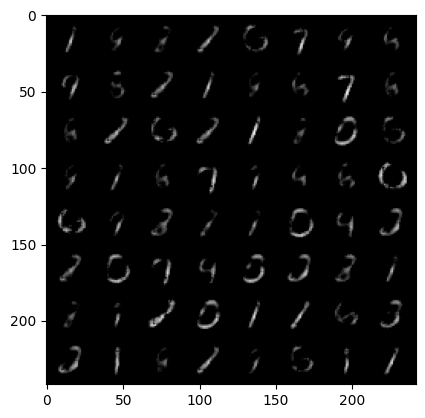

EPOCH: 1.886  valid_loss: 15979.886  (12.01s - 51.68s remaining))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 2.000  train_loss: 18722.240  valid_loss: 17968.616  (12.08s - 48.34s remaining)


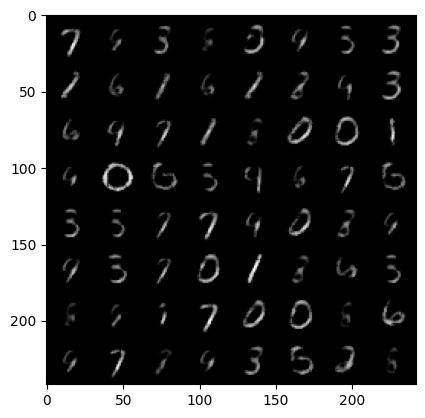

EPOCH: 2.911  valid_loss: 19553.342  (17.97s - 43.75s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 3.000  train_loss: 17821.349  valid_loss: 17304.573  (18.02s - 42.05s remaining)


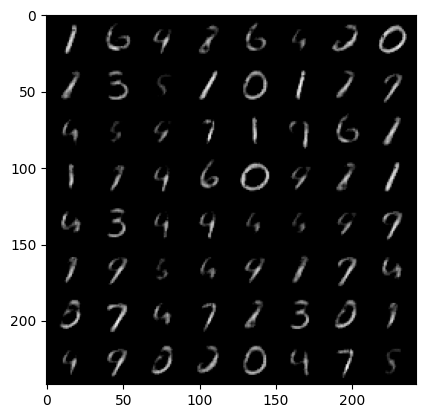

EPOCH: 3.911  valid_loss: 19259.863  (23.91s - 37.21s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 4.000  train_loss: 17355.698  valid_loss: 17020.927  (23.96s - 35.94s remaining)


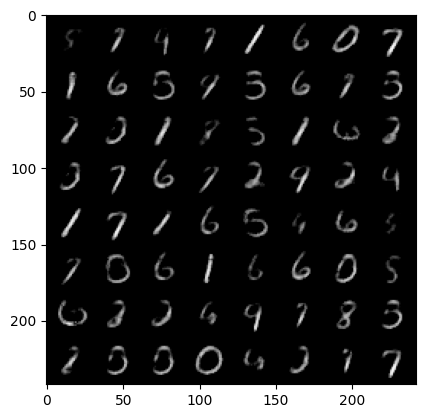

EPOCH: 4.924  valid_loss: 15535.077  (29.92s - 30.85s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 5.000  train_loss: 17042.720  valid_loss: 16871.840  (29.97s - 29.97s remaining)


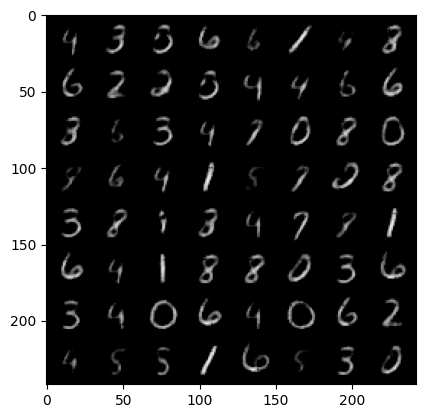

EPOCH: 5.937  valid_loss: 15844.951  (35.86s - 24.54s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 6.000  train_loss: 16842.171  valid_loss: 16670.293  (35.90s - 23.93s remaining)


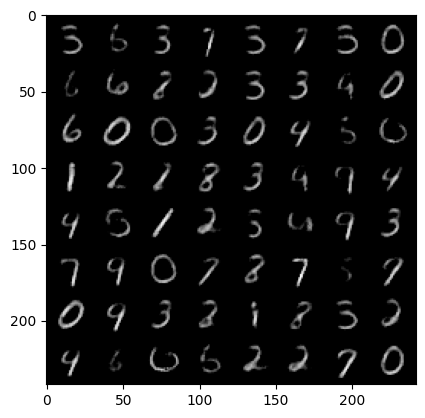

EPOCH: 6.848  valid_loss: 18905.795  (41.76s - 19.22s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 7.000  train_loss: 16658.179  valid_loss: 16564.553  (41.85s - 17.94s remaining)


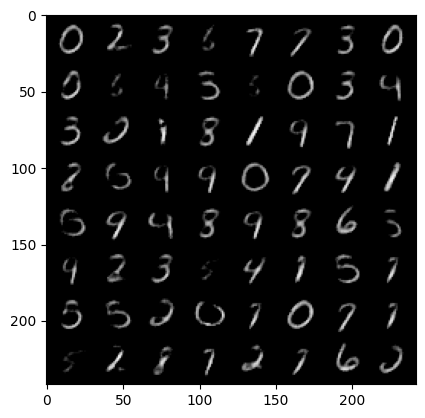

EPOCH: 7.975  valid_loss: 16013.143  (47.77s - 12.13s remaining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 8.000  train_loss: 16512.192  valid_loss: 16467.918  (47.78s - 11.94s remaining)


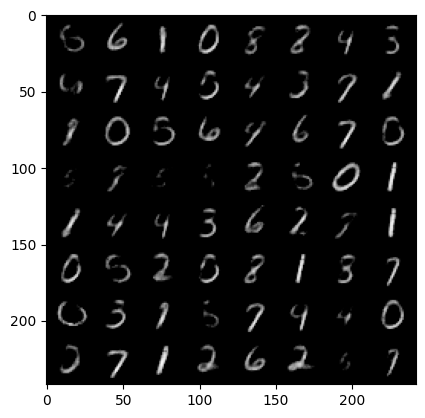

EPOCH: 8.911  valid_loss: 18314.141  (53.66s - 6.55s remaining))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 9.000  train_loss: 16392.233  valid_loss: 16350.653  (53.71s - 5.97s remaining)


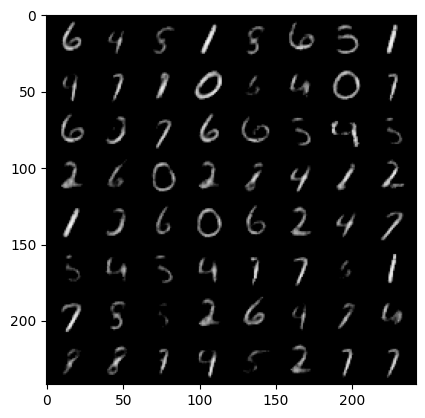

EPOCH: 9.911  valid_loss: 18409.406  (59.62s - 0.53s remaining))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 10.000  train_loss: 16263.891  valid_loss: 16329.789  (59.67s - 0.00s remaining)


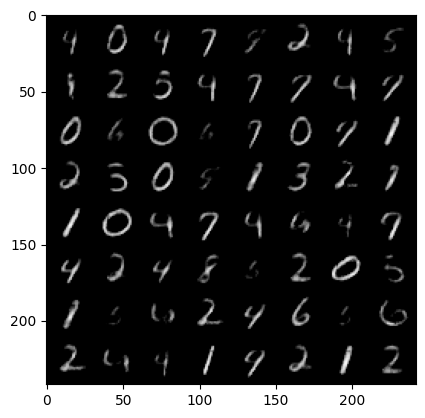

In [12]:
from torch_snippets import *
from torchvision.utils import make_grid

n_epochs = 10
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trainLoader)
    
    for batchIndex, (imageSet, labelSet) in enumerate(trainLoader):
        imageSet = imageSet.to(device)
        
        optimizer.zero_grad()
        recon_imageSet, mu, log_var = model(imageSet)
        loss = lossFunction(recon_imageSet, imageSet, mu, log_var)
        loss.backward()
        optimizer.step()
        
        log.record(epoch+(batchIndex+1)/N, train_loss=loss.item(), end='\r')
        
        
    N = len(validationLoader)
    
    for batchIndex, (imageSet, labelSet) in enumerate(validationLoader):
        
        imageSet = imageSet.to(device)
        recon_imageSet, mu, log_var = model(imageSet)
        loss = lossFunction(recon_imageSet, imageSet, mu, log_var)
        
        log.record(epoch+(batchIndex+1)/N, valid_loss=loss.item(), end='\r')
        
    log.report_avgs(epoch+1)
    
    # plot new generated images
    with torch.no_grad():
        z = torch.randn(64, 2).to(device)
        samples = model.decoder(z).cpu()
        grid = make_grid(samples).permute(1, 2, 0)
        plt.imshow(grid)
        plt.show()
    



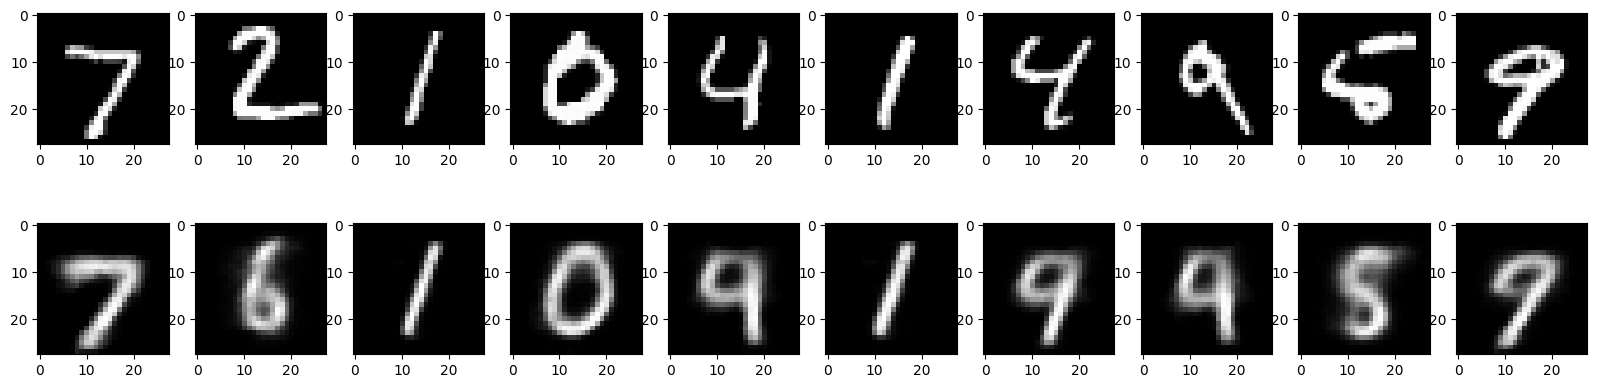

In [13]:
# See reconstructed samples of randomly selected images from the validation set
# plot original vs recnstructed images in same grid
# make sure evrything is on same device

with torch.no_grad():
    for imageSet, labelSet in validationLoader:
        imageSet = imageSet.to(device)
        recon_imageSet, _, _ = model(imageSet)
        break

    N = 10
    fig, axes = plt.subplots(2,N, figsize=(20, 5))
    for i in range(N):
        axes[0, i].imshow(imageSet[i].cpu().numpy().squeeze(), cmap='gray')
        axes[1, i].imshow(recon_imageSet[i].cpu().numpy().squeeze(), cmap='gray')
        
    plt.show()

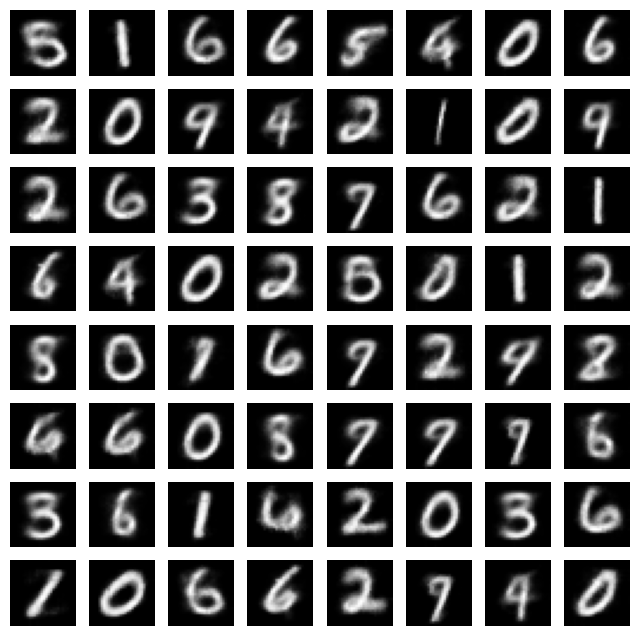

In [15]:
# Generate new images
import matplotlib.pyplot as plt

with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    samples = model.decoder(z).cpu()
    samples = samples.view(64, 28, 28)
    
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(samples[i*8+j], cmap='gray')
            ax[i, j].axis('off')
    
    plt.show()
    